# DEA Coastlines raster generation <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts raster generation for DEA Coastlines:

* Load stack of all available Landsat 5, 7 and 8 satellite imagery for a location using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html)
* Convert each satellite image into a remote sensing water index (MNDWI)
* For each satellite image, model ocean tides into a 2 x 2 km grid based on exact time of image acquisition
* Interpolate tide heights into spatial extent of image stack
* Mask out high and low tide pixels by removing all observations acquired outside of 50 percent of the observed tidal range centered over mean sea level
* Combine tidally-masked data into annual median composites from 1988 to the present representing the coastline at approximately mean sea level

This is an interactive version of the code intended for prototyping; to run this analysis at scale, run `dea_coastlines.raster.py`.

---

In [ ]:
pip install mock

In [ ]:
pip install topojson

## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [15]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import datacube
import geopandas as gpd
import multiprocessing
import xarray as xr
from functools import partial
from datacube.utils.geometry import Geometry
from dea_tools.dask import create_local_dask_cluster

# Load raster generation DEA Coastlines code
sys.path.insert(0, '..')
import dea_coastlines.raster

# Connect to datacube
dc = datacube.Datacube(app='DEA_Coastlines')

# Create local dask client for parallelisation
client = create_local_dask_cluster(return_client=True)


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45369 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37001 Dashboard: /user/robbibt/proxy/45369/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


### Load supplementary data

In [5]:
study_area = 8335
raster_version = 'refactor_test'

# Tide points are used to model tides across the extent of the satellite data
points_gdf = gpd.read_file('../data/raw/tide_points_coastal.geojson')

# Albers grid cells used to process the analysis
gridcell_gdf = (gpd.read_file('../data/raw/50km_albers_grid_clipped.geojson')
                .to_crs(epsg=4326)
                .set_index('id')
                .loc[[study_area]])

## Loading data
### Create query


In [8]:
# Create query
geopoly = Geometry(gridcell_gdf.iloc[0].geometry, crs=gridcell_gdf.crs)
query = {'geopolygon': geopoly.buffer(0.05),
         'time': ('1987', '2020'),  # 1987, 2020
         'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}}


### Load virtual product

In [9]:
# Load virtual product
ds = dea_coastlines.raster.load_mndwi(
    dc,
    query,
    yaml_path='../configs/deacoastlines_virtual_products_v1.0.0.yaml',
    product_name='ls_nbart_mndwi')
ds

<xarray.Dataset>
Dimensions:      (time: 1353, y: 873, x: 480)
Coordinates:
  * time         (time) datetime64[ns] 1987-05-22T23:07:20.148864 ... 2020-12...
  * y            (y) float64 -3.492e+06 -3.492e+06 ... -3.518e+06 -3.518e+06
  * x            (x) float64 4.841e+05 4.841e+05 ... 4.984e+05 4.985e+05
    spatial_ref  int32 32656
Data variables:
    mndwi        (time, y, x) float32 dask.array<chunksize=(1, 873, 480), meta=np.ndarray>
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

## Tidal modelling
### Model tides at point locations

/home/jovyan/Robbi/dea-coastlines/notebooks/../dea_coastlines/raster.py:196: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_vals = subset_gdf.geometry.centroid.x
/home/jovyan/Robbi/dea-coastlines/notebooks/../dea_coastlines/raster.py:197: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_vals = subset_gdf.geometry.centroid.y


<AxesSubplot:>

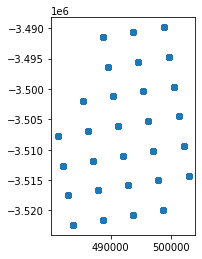

In [10]:
tidepoints_gdf = dea_coastlines.raster.model_tides(ds, points_gdf)
tidepoints_gdf.plot()

### Interpolate tides into each satellite timestep

In [16]:
pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
print(f'Parallelising {multiprocessing.cpu_count() - 1} processes')
out_list = pool.map(partial(dea_coastlines.raster.interpolate_tide,
                            tidepoints_gdf=tidepoints_gdf,
                            factor=50), 
                    iterable=[group for (i, group) in ds.groupby('time')])
pool.close()
pool.join()

# Combine to match the original dataset
ds['tide_m'] = xr.concat(out_list, dim=ds['time'])

Parallelising 15 processes


<AxesSubplot:title={'center':'time = 2020-03-13T23:43:11.256570, spatial_ref ...'}, xlabel='x', ylabel='y'>

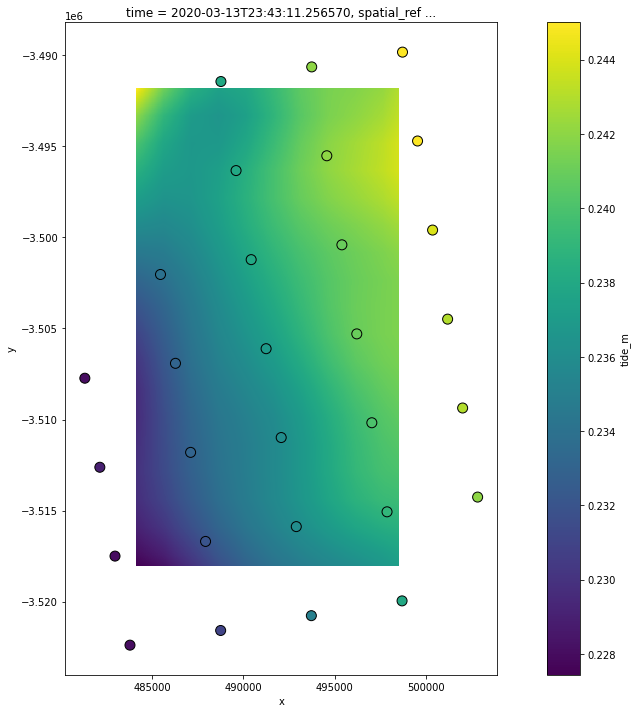

In [18]:
import matplotlib.pyplot as plt

# Plot 
ds_i = ds['tide_m'].isel(time=-45).compute()
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(),
                                                     vmax=ds_i.max().item())


In [19]:
# Determine tide cutoff
tide_cutoff_buff = (
    (ds['tide_m'].max(dim='time') - ds['tide_m'].min(dim='time')) * 0.25)
tide_cutoff_min = 0.0 - tide_cutoff_buff
tide_cutoff_max = 0.0 + tide_cutoff_buff

## Generate yearly composites

In [20]:
# If output folder doesn't exist, create it
output_dir = f'../data/interim/raster/{raster_version}/{study_area}_{raster_version}'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each year and export annual and 3-year gapfill composites
dea_coastlines.raster.export_annual_gapfill(ds, output_dir, tide_cutoff_min,
                                            tide_cutoff_max)

Processing 1987


CPLReleaseMutex: Error = 1 (Operation not permitted)


Processing 1988
Processing 1989
Processing 1990
Processing 1991
Processing 1992
Processing 1993
Processing 1994
Processing 1995
Processing 1996
Processing 1997
Processing 1998
Processing 1999
Processing 2000
Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006
Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** November 2021